In [ ]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics, DelaunayTriangulation, CairoMakie
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]


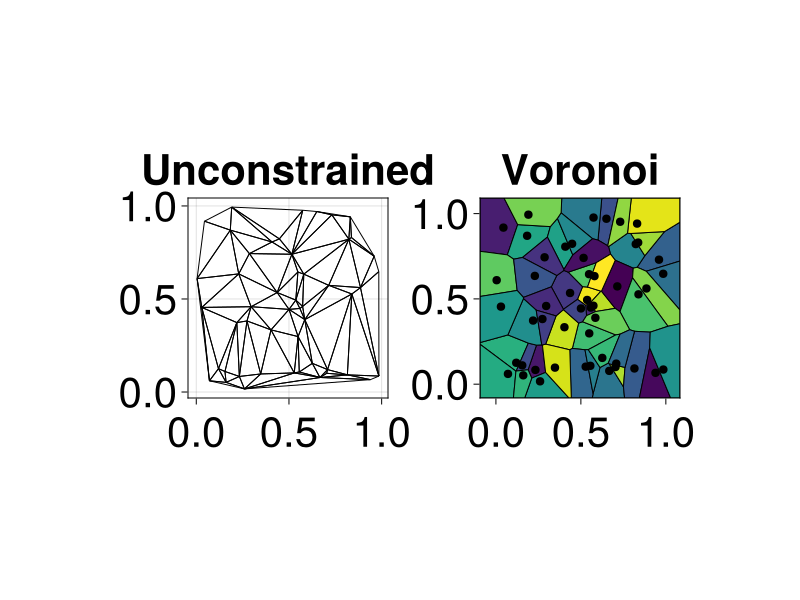

In [19]:
using DelaunayTriangulation, CairoMakie, StableRNGs

# Unconstrained points and triangulation
points = rand(2, 50)
tri1 = triangulate(points)  # default predicate kernel is AdaptiveKernel()

# Voronoi example
vorn2 = voronoi(tri1)

# Set up the figure and plot
fig = Figure(fontsize = 42, size = (280, 220))
wh = (width = 200, height = 200)

# Unconstrained Triangulation Plot
ax1 = Axis(fig[1, 1]; title = "Unconstrained", wh...)
triplot!(ax1, tri1)  # Update with actual triangulation plot function if needed

# Voronoi Plot
ax2 = Axis(fig[1, 2]; title = "Voronoi", wh...)
voronoiplot!(ax2, vorn2)  # Update with actual Voronoi plot function if needed

# Display the figure
fig


Iter     Function value   Gradient norm 
     1     3.413519e+05              NaN
 * time: 0.08299994468688965
     2     3.352391e+05              NaN
 * time: 1.0360000133514404
     3     3.352391e+05              NaN
 * time: 1.0429999828338623
     4     3.352391e+05              NaN
 * time: 1.0429999828338623
     5     3.352391e+05              NaN
 * time: 1.0429999828338623
     6     3.334929e+05              NaN
 * time: 1.0429999828338623
     7     3.334929e+05              NaN
 * time: 1.0429999828338623
     8     3.316422e+05              NaN
 * time: 1.0429999828338623
     9     3.292952e+05              NaN
 * time: 1.0429999828338623
    10     3.289929e+05              NaN
 * time: 1.0429999828338623
    11     3.289929e+05              NaN
 * time: 1.0429999828338623
    12     3.289929e+05              NaN
 * time: 1.0429999828338623
    13     3.282192e+05              NaN
 * time: 1.0429999828338623
    14     3.282192e+05              NaN
 * time: 1.042999982

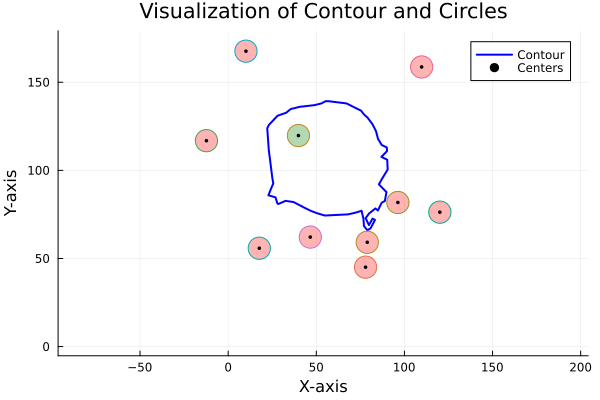

68.761471.2863
45.8114106.12357
52.21264379.3558
71.7123886.50297
45.99555693.477554
59.053333110.33602
62.372295.65396
81.5559895.41691
70.623116105.20648
49.99363119.83202


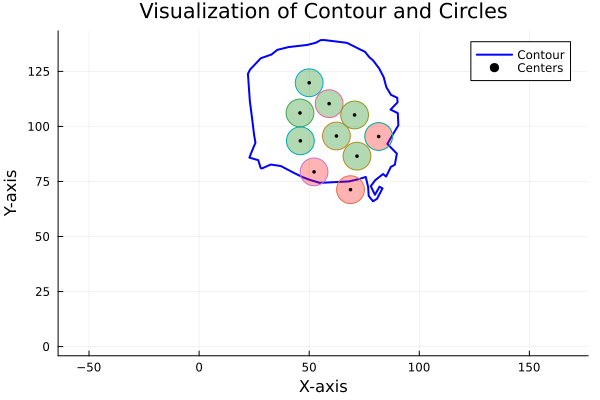

In [1]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics, DelaunayTriangulation

# Define a Circle struct
struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=0.5)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min
    
    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio
    
    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground
function make_circles(num_circles; radius=6.3, x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position
    
    for i in 1:num_circles
        attempts = 0
        while attempts < max_attempts
            x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
            y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
            overlap = false
            
            # Check if this circle overlaps with any existing circles
            for circle in circles
                if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                    overlap = true
                    break
                end
            end
            
            if !overlap
                # Store the circle with its properties
                push!(circles, Circle(x, y, radius, i))
                break
            end
            
            attempts += 1
        end
        
        # If no non-overlapping position found after max attempts, skip this circle
        if attempts == max_attempts
            println("Failed to place circle $i after $max_attempts attempts")
        end
    end
    
    return circles  # Return an array of circles
end

function distance_to_nearest_edge(circle::Circle, polygon_x, polygon_y)
    nearest_distance = Inf  # Start with a very large distance
    num_points = length(polygon_x)

    # Iterate through each edge of the polygon
    for i in 1:num_points
        x1, y1 = polygon_x[i], polygon_y[i]  # Start point of the edge
        x2, y2 = polygon_x[mod1(i, num_points + 1)], polygon_y[mod1(i, num_points + 1)]  # End point of the edge

        # Calculate the distance from the circle's center to the line segment
        distance = point_to_line_segment_distance(circle.x_coord, circle.y_coord, x1, y1, x2, y2)
        nearest_distance = min(nearest_distance, distance)
    end

    return nearest_distance
end

# Function to calculate distance from a point to a line segment
function point_to_line_segment_distance(px, py, x1, y1, x2, y2)
    dx = x2 - x1
    dy = y2 - y1
    if (dx == 0) && (dy == 0)  # The line segment is a single point
        return sqrt((px - x1)^2 + (py - y1)^2)
    end

    # Calculate the projection of the point onto the line segment
    t = ((px - x1) * dx + (py - y1) * dy) / (dx^2 + dy^2)
    t = clamp(t, 0.0, 1.0)  # Clamp t to the range [0, 1]

    # Find the closest point on the line segment
    closest_x = x1 + t * dx
    closest_y = y1 + t * dy

    # Calculate the distance from the point to the closest point on the segment
    return sqrt((px - closest_x)^2 + (py - closest_y)^2)
end


# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    circle_energy = 0.0
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_penalty = 1e12
    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) -(circle1.radius + circle2.radius)
            if distance > 0
                # energy
                circle_energy += distance^2
            else 
                circle_energy += repulsion_penalty
            end
        end
    end

    
    repulsion_strength = 1e6  # Strength of repulsion from the contour
    
    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary

    for circle in circles
         # 1. Attraction to the center of the contour
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2  # Attraction force to the center
 
         # 2. Repulsion from the contour boundary
        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if circle_in_polygon(circle, circle.x_coord, circle.y_coord) # Circle is touching or outside the boundary
                repell_energy += 1 / distance_to_boundary * repulsion_strength  
            end
        end
    end

    # Total energy
    total_energy = circle_energy + 2*center_energy + repell_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        # Check if the circle is completely inside the contour
        if circle_in_polygon(circle, smooth_x, smooth_y)
            # Plot circle inside with green color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
            println(circle.x_coord, circle.y_coord)           
        else
            # Plot circle outside with red color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
            println(circle.x_coord, circle.y_coord)           
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end


# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]


# Generate fine splines and interpolated points for the contour
smooth_x, smooth_y = create_fine_spline(x, y)

# Determine the playground dimensions
x_min, x_max, y_min, y_max = make_playground(x, y)

num_circles = 10
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

function optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
    function objective(params)
        num_circles = length(circles)
        updated_circles = [Circle(params[2*i-1], params[2*i], circles[i].radius, circles[i].label) for i in 1:num_circles]
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    # Flatten x and y coordinates into the initial_params array
    initial_params = [i % 2 == 1 ? circles[(i+1) ÷ 2].x_coord : circles[i ÷ 2].y_coord for i in 1:(2*length(circles))]

    # Set up the optimization with termination on insufficient decrease and max iterations
    options = Optim.Options(
        show_trace = true,   # Show trace of optimization steps
        #f_tol = 1e-8,        # Terminate when the improvement in the function value is less than this tolerance
        #g_tol = 1e-6,        # Gradient tolerance
        iterations = 1000   # Maximum number of iterations (stops when t = 10)
    )

    # Perform the optimization using NelderMead with the defined options
    result = optimize(objective, initial_params, SimulatedAnnealing(), options)
    optimized_params = Optim.minimizer(result)

    # Create a new list of updated circles using the optimized x and y coordinates
    updated_circles = [Circle(optimized_params[2*i-1], optimized_params[2*i], circles[i].radius, circles[i].label) for i in 1:length(circles)]
    
    return updated_circles
end

# Example call to optimization
optimized_circles = optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
visualize_contour_and_circles(smooth_x, smooth_y, circles)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)



In [54]:
using DelaunayTriangulation, CairoMakie, StableRNGs

# Unconstrained 
points = rand(2, 50)
tri1 = triangulate(points) # default predicate kernel is AdaptiveKernel()

# Voronoi example 
vorn2 = voronoi(tri1)

Voronoi Tessellation.
    Number of generators: 50
    Number of polygon vertices: 87
    Number of polygons: 50

In [25]:
using Delaunay

# Define some points in 2D
points = [0.0 0.0; 1.0 0.0; 1.0 1.0; 0.0 1.0; 0.5 0.5]

# Compute the Delaunay triangulation
tri = delaunay(points)

# Extract the triangles (each row represents a triangle with vertex indices)
triangles = tri.simplices

# Create an empty adjacency matrix
connectivity_matrix = zeros(Bool, size(points, 1), size(points, 1))

# Fill the connectivity matrix based on the triangles
for triangle in eachrow(triangles)
    connectivity_matrix[triangle[1], triangle[2]] = true
    connectivity_matrix[triangle[2], triangle[3]] = true
    connectivity_matrix[triangle[3], triangle[1]] = true
    # Ensure the matrix is symmetric
    connectivity_matrix[triangle[2], triangle[1]] = true
    connectivity_matrix[triangle[3], triangle[2]] = true
    connectivity_matrix[triangle[1], triangle[3]] = true
end

# Print the connectivity matrix
println("Connectivity Matrix:")
println(connectivity_matrix)

Connectivity Matrix:
Bool[0 1 0 1 1; 1 0 1 0 1; 0 1 0 1 1; 1 0 1 0 1; 1 1 1 1 0]


Iter     Function value   Gradient norm 
     1     6.846900e+06              NaN
 * time: 0.0
     2     6.830372e+06              NaN
 * time: 0.0009999275207519531
     3     6.830372e+06              NaN
 * time: 0.003000020980834961
     4     6.830372e+06              NaN
 * time: 0.003999948501586914
     5     6.777334e+06              NaN
 * time: 0.003999948501586914
     6     6.768294e+06              NaN
 * time: 0.005000114440917969
     7     6.768294e+06              NaN
 * time: 0.006000041961669922
     8     6.723566e+06              NaN
 * time: 0.006999969482421875
     9     6.723566e+06              NaN
 * time: 0.006999969482421875
    10     6.717692e+06              NaN
 * time: 0.00800013542175293
    11     6.659098e+06              NaN
 * time: 0.009000062942504883
    12     6.659098e+06              NaN
 * time: 0.009000062942504883
    13     6.594514e+06              NaN
 * time: 0.009999990463256836
    14     6.594514e+06              NaN
 * time: 0.0

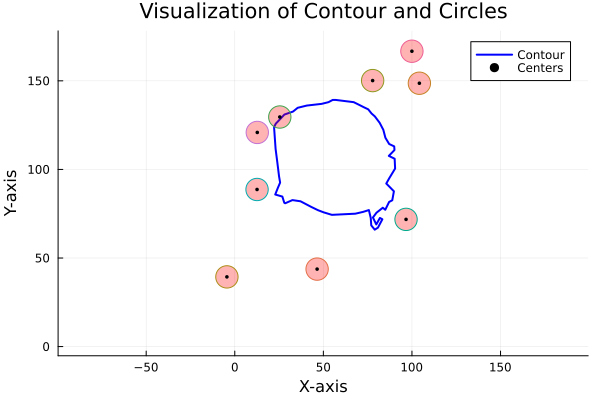

59.94775483.6274
52.754272123.53383
51.255592105.16833
41.83856274.06856
48.76733890.76011
76.28393116.861015
62.340385113.93923
75.3796391.56377
72.605934104.66614


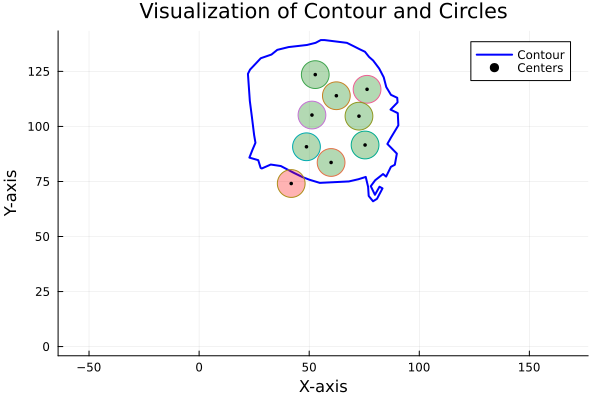

In [8]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics, DelaunayTriangulation

# Define a Circle struct
struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=60)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=0.5)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min
    
    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio
    
    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground
function make_circles(num_circles; radius=6.3, x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position
    
    for i in 1:num_circles
        attempts = 0
        while attempts < max_attempts
            x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
            y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
            overlap = false
            
            # Check if this circle overlaps with any existing circles
            for circle in circles
                if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                    overlap = true
                    break
                end
            end
            
            if !overlap
                # Store the circle with its properties
                push!(circles, Circle(x, y, radius, i))
                break
            end
            
            attempts += 1
        end
        
        # If no non-overlapping position found after max attempts, skip this circle
        if attempts == max_attempts
            println("Failed to place circle $i after $max_attempts attempts")
        end
    end
    
    return circles  # Return an array of circles
end

function create_delaunay_connectivity(circles)
    points = [(circle.x_coord, circle.y_coord) for circle in circles]
    tri = triangulate(points)
    connectivity = Dict(i => Int[] for i in 1:length(circles))

    # Access the triangles property
    for triangle in tri.triangles
        # Ensure the triangle is a triplet
        if length(triangle) == 3
            for (i, j) in [(triangle[1], triangle[2]), (triangle[2], triangle[3]), (triangle[3], triangle[1])]
                if j ∉ connectivity[i]  # Avoid duplicate entries
                    push!(connectivity[i], j)
                end
                if i ∉ connectivity[j]  # Avoid duplicate entries
                    push!(connectivity[j], i)
                end
            end
        end
    end

    return connectivity
end

function create_binary_connectivity_matrix(circles)
    # Generate connectivity using the Delaunay triangulation
    connectivity = create_delaunay_connectivity(circles)
    
    # Initialize a binary matrix with zeros
    N = length(circles)
    binary_matrix = zeros(Int, N, N)
    
    # Populate the matrix based on connectivity
    for (i, neighbors) in connectivity
        for j in neighbors
            binary_matrix[i, j] = 1
            binary_matrix[j, i] = 1  # Ensure symmetry
        end
    end

    return binary_matrix
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    circle_energy = 0.0
    center_energy = 0.0
    repell_energy = 0.0

    repulsion_penalty = 1e12
    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    # Create the binary connectivity matrix
    binary_matrix = create_binary_connectivity_matrix(circles)

    # Compute circle energy using the binary connectivity matrix
    for i in 1:length(circles)
        for j in 1:length(circles)
            if binary_matrix[i, j] == 1 && j > i  # Only consider upper triangle for unique pairs
                circle1, circle2 = circles[i], circles[j]
                distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
                if distance > 0
                    circle_energy += distance^2
                else 
                    circle_energy += repulsion_penalty
                end
            end
        end
    end

    
    repulsion_strength = 1e6  # Strength of repulsion from the contour
    
    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary

    for circle in circles
         # 1. Attraction to the center of the contour
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        center_energy += distance_to_center^2  # Attraction force to the center
 
         # 2. Repulsion from the contour boundary
        for (px, py) in zip(smooth_x, smooth_y)
            distance_to_boundary = sqrt((px - circle.x_coord)^2 + (py - circle.y_coord)^2) - circle.radius
            if circle_in_polygon(circle, circle.x_coord, circle.y_coord) # Circle is touching or outside the boundary
                repell_energy += 1 / distance_to_boundary * repulsion_strength  
            end
        end
    end

    # Total energy
    total_energy = circle_energy + 200*center_energy + 0*repell_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        # Check if the circle is completely inside the contour
        if circle_in_polygon(circle, smooth_x, smooth_y)
            # Plot circle inside with green color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
            println(circle.x_coord, circle.y_coord)           
        else
            # Plot circle outside with red color
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
            println(circle.x_coord, circle.y_coord)           
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end


# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]


# Generate fine splines and interpolated points for the contour
smooth_x, smooth_y = create_fine_spline(x, y)

# Determine the playground dimensions
x_min, x_max, y_min, y_max = make_playground(x, y)

num_circles = 9
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

function optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
    function objective(params)
        num_circles = length(circles)
        updated_circles = [Circle(params[2*i-1], params[2*i], circles[i].radius, circles[i].label) for i in 1:num_circles]
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    # Flatten x and y coordinates into the initial_params array
    initial_params = [i % 2 == 1 ? circles[(i+1) ÷ 2].x_coord : circles[i ÷ 2].y_coord for i in 1:(2*length(circles))]

    # Set up the optimization with termination on insufficient decrease and max iterations
    options = Optim.Options(
        show_trace = true,   # Show trace of optimization steps
        #f_tol = 1e-8,        # Terminate when the improvement in the function value is less than this tolerance
        #g_tol = 1e-6,        # Gradient tolerance
        iterations = 1000   # Maximum number of iterations (stops when t = 10)
    )

    # Perform the optimization using NelderMead with the defined options
    result = optimize(objective, initial_params, SimulatedAnnealing(), options)
    optimized_params = Optim.minimizer(result)

    # Create a new list of updated circles using the optimized x and y coordinates
    updated_circles = [Circle(optimized_params[2*i-1], optimized_params[2*i], circles[i].radius, circles[i].label) for i in 1:length(circles)]
    
    return updated_circles
end

# Example call to optimization
optimized_circles = optimize_circles(circles, smooth_x, smooth_y, x_min, x_max, y_min, y_max)
visualize_contour_and_circles(smooth_x, smooth_y, circles)
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)



In [ ]:
using DelaunayTriangulation

# Define a Circle struct for testing purposes
struct Circle
    x_coord::Float64
    y_coord::Float64
    radius::Float64b
end

# Test function for `create_delaunay_connectivity`
function test_create_delaunay_connectivity()
    # Create sample circles
    circles = [
        Circle(0.0, 0.0, 1.0),
        Circle(1.0, 0.0, 1.0),
        Circle(0.5, 1.0, 1.0),
        Circle(-0.5, 1.0, 1.0),
        Circle(-1.0, 0.0, 1.0)
    ]

    # Call the function to create connectivity
    connectivity = create_delaunay_connectivity(circles)

    # Output the connectivity for inspection
    println("Delaunay connectivity matrix:")
    for (circle, neighbors) in connectivity
        println("Circle $circle is connected to circles: $neighbors")
    end

    # Check connectivity structure
    # For example, we expect circle 1 to connect with circle 2 and circle 3, etc.
    # Assert statements can be used here if specific connectivity is known
    # Here we will just check if connectivity is not empty
    for neighbors in values(connectivity)
        @assert length(neighbors) > 0 "Each circle should have at least one neighbor"
    end

    println("Test passed! All circles have neighbors.")
end

# Run the test
test_create_delaunay_connectivity()

LoadError: invalid redefinition of constant Main.Circle